In [1]:
from transformers import GPT2LMHeadModel
import datasets

/Users/sydneysim/Documents/codingProjects/GPT2-exploration/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GPT-2 (124M) Architecture Overview

GPT-2 is a decoder-only transformer model trained with causal language modeling. The 124M version has ~124 million parameters and 12 stacked transformer blocks.

---

## Key Hyperparameters

| Component            | Value            |
|---------------------|------------------|
| Layers              | 12               |
| Hidden size         | 768              |
| Attention heads     | 12               |
| Context length      | 1024 tokens      |
| Vocabulary size     | 50257 tokens     |
| MLP (inner dim)     | 3072             |
| Activation function | GELU             |

---

## Architecture Components

### 1. **Input Embeddings**
- `transformer.wte.weight` — wte: word/token embeddings `[50257, 768]`
- `transformer.wpe.weight` — word positional embeddings `[1024, 768]`

- Combined as:  
x = token_embedding + position_embedding

---

### 2. **12 Transformer Blocks**
Each block consists of:

#### a. LayerNorm (Pre-Attention)
- `ln_1.weight` / `ln_1.bias`: `[768]`

#### b. Multi-Head Self-Attention
- `c_attn.weight`: `[768, 2304]` → for Q, K, V (concatenated)
- `c_attn.bias`: `[2304]`
- `c_proj.weight`: `[768, 768]` — output projection
- `c_proj.bias`: `[768]`

#### c. LayerNorm (Pre-MLP)
- `ln_2.weight` / `ln_2.bias`: `[768]`

#### d. Feedforward MLP
- `c_fc.weight`: `[768, 3072]` — expand dim 4×
- `c_fc.bias`: `[3072]`
- `c_proj.weight`: `[3072, 768]` — project back
- `c_proj.bias`: `[768]`

Each block does:

```python
x = x + Attention(LayerNorm(x))
x = x + MLP(LayerNorm(x))
```

### 3. Final LayerNorm

- `transformer.ln_f.weight`, `transformer.ln_f.bias`: `[768]`

### 4. Output Head

- `lm_head.weight`: `[50257, 768]` — maps final hidden state to vocabulary logits
- Often tied to `transformer.wte.weight` (token embedding matrix)

---

### Flow of Data

Input Tokens  
↓  
Token Embedding + Positional Embedding  
↓  
[Transformer Block 1]  
↓  
[Transformer Block 2]  
↓  
...  
↓  
[Transformer Block 12]  
↓  
Final LayerNorm  
↓  
Linear → Logits over vocabulary

---


Some questions that I had:

#### max sequence length is 1024, what does that mean? 
- Max sequence length means the model can see and process up to 1024 tokens in a single forward pass. This is the HARD LIMIT for the attention mechanism in this model, meaning at each token, the odel can only look back up to 1023 tokens
- If the max sequence length is 1024, this means that the prompt+generation tokens can not exceed 1024
- past 1024, the model will not crash, but it would not be able to understand anything past 1024, meaning most outputs will me meaningless garbage (for testing later)
- this is as `wpe.weight`, the word position embeddings matrix which is one of the first layers of the whole block, only has 1024 entries

#### so if we want longer seq length, will it be as easy as increasing `wpe.weights` dimensions?
- Answer is yes and no, meaning when we increase the dimensions to lets say 2048, the model will have more positional embedding dimensions, but these additional positions will remain untrained, meaning outputs are still garbage
- what we can do is extend wpe from [1024, 768] to [2048, 768]
- Fine-tune or retrain the model again with a larger sequence length, as the existing one only accepts up to 1024
- Alternatively, we could use RoPe (Rotary Positional Embeddings) (which i think would effectively turn it into gpt-3) as it is not a 'lookup table' stle absolute positional embeddings but a math function
- This would make it generalisable to longer sequences if scaled properly





In [6]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

#### Since this is a dictionary, we can look at whichever part of the model architechture like so


In [7]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

Visualising the word position embeddings layer, keep in mind that:

- Every row is a index in the word position embeddings layer from 0 to 1024
- Every column is a dimension in the word embeddings

This enables to model to look at each token not just in terms of content, but also position in the sequence

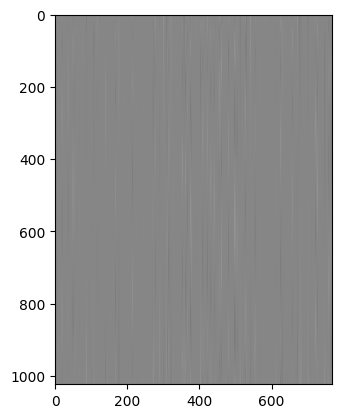

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

Here we visualise 3 different channels (cols) in the WPE for rows 0 to 1024, we can see that green channel fires for position 200 to 800, which we have no idea what it means, but its quite cool to see

Another cool observation is that in the beginning of the optimisation, this matrix is completely random, and the graph should be in principal completely noisy. But after training, this noise smoothens out a little and the graph can be seen to have some sort of sinusoidal properties

Of course this position embeddings model is still pretty noisy looking and not very smooth, which suggests that it still is undertrained

Originally in the [attention is all you need paper](https://arxiv.org/abs/1706.03762), the WPE matrices were initialised and fixed to just sine and cosine curves with differing frequencies, but in GPT-2 they are learned like any other param


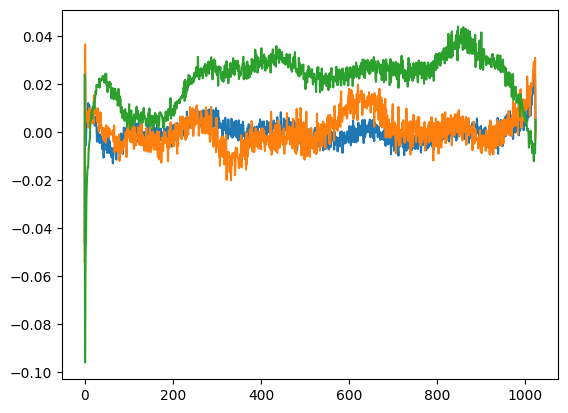

In [9]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

Visualisation of first transformer block weights, there is some kind of structure that can be seen, but who knows ah

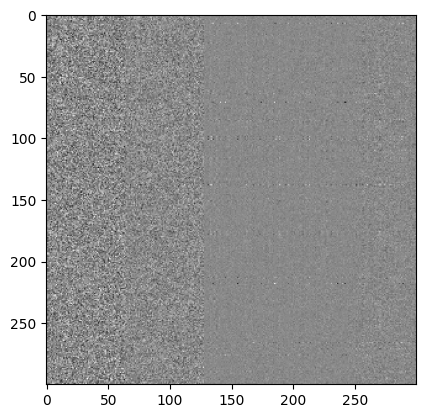

In [10]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

Now the interesting part, we test our generation

In [19]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("What is 1+1", max_new_tokens=30, num_return_sequences=5)

Device set to use mps:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'What is 1+1+1+1+1+1+1+1+1+1+1+1+1+1?\n\nAnswer\n\n'},
 {'generated_text': 'What is 1+1=1?\n\nThe answer is that you may or may not be able to use them. To get the 3 of them, you simply need'},
 {'generated_text': 'What is 1+1?\n\nWhen a person is shown the ability to perceive one another as well as to manipulate others, they can use their ability to perceive a person'},
 {'generated_text': 'What is 1+1=1+2?\n\nIf you are using 1+1=1+2, do not use a non-canonical character. Do'},
 {'generated_text': 'What is 1+1+1+1+1+1+1+1+1+1+1?\n\nYes, i agree with the above statement.'}]

In [8]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("winglian/tiny-shakespeare")

Generating test split: 100%|██████████| 49/49 [00:00<00:00, 30281.55 examples/s]


The tiny shakespeare dataset is no longer avail from karpathys repo

In [25]:
with open('./input.txt', 'w') as f:
    for row in ds['train']:
        f.write(row['text'])

In [26]:
with open('./input.txt', 'a') as f:
    for row in ds['test']:
        f.write(row['text'])

In [27]:
with open('./input.txt', 'r') as f:
    text=f.read()


data=text[:1000]
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [29]:
import tiktoken

enc=tiktoken.get_encoding('gpt2')
tokens=enc.encode(data)
first_24=tokens[:24]
print(first_24)


[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


Here we kind of demonstrate how to create a 2d minibatch of tokens, along with creating a target label tensor


In [33]:
import torch 

buf=torch.tensor(tokens[:24+1])
x=buf[:-1].view(4, 6)
y=buf[1:].view(4, 6) #just shifted one down essentially



print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [34]:
sd_hf["lm_head.weight"]
sd_hf["transformer.h.1.attn.c_attn.weight"]

NameError: name 'sd_hf' is not defined